In [29]:
from matplotlib import pyplot as pl
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from astroviper.core.imaging.fft import fft_lm_to_uv

# Demo of standard degridder

[Colab Link](https://colab.research.google.com/github/casangi/astroviper/blob/main/docs/core_tutorials/imaging/demo_standard_degrid.ipynb)


Description of notebook

The intial demo is to Fourier transform an image with 4 sources.
We degrid that onto the VISIBILITY_MODEL of a xarray ms4 dataset.
Then we grid those model visibility data with the same convolution using the standard gridder and Fourier transform that back to an image and compare the source position and values
The second part compare with casa prediction using a standard gridder and a given model image.

## Assumptions

The centre pixel is assumed to be the phasecentre.

---
## Pseudo Code 

**For example:**

- ms4 Measurement Set v4 Data Tree
- grid is FT of model image
- pixelincr numparray of size 2 (dx, dy) with values in radians 
```
core/imaging/imaging_utils/standard_degrid.py

    degrid_spheroid_ms4(ms4, grid, pixelincr, incremental=False) 

    
```

The model visibilities is saved on the VISIBILITY_MODEL dataArray of ms4

---
## API

## Install AstroVIPER



In [ ]:
from importlib.metadata import version
import os

try:
    os.system("pip install --upgrade astroviper")

    import astroviper

    print("Using astroviper version", version("astroviper"))

except ImportError as exc:
    print(f"Could not import astroviper: {exc}")

In [10]:
from astroviper.core.imaging.imaging_utils.standard_degrid import degrid_spheroid_ms4
help(degrid_spheroid_ms4)    


Help on function degrid_spheroid_ms4 in module astroviper.core.imaging.imaging_utils.standard_degrid:

degrid_spheroid_ms4(vis: xarray.core.datatree.DataTree, grid: numpy.ndarray, pixelincr: numpy.ndarray, support: int = 7, sampling: int = 100, incremental: bool = False, whichFunc=0)
    Parameters
    ----------
    vis : xarray.core.datatree.DataTree
        ms4 xradio datatree.
    grid : np.ndarray
        model gridded visibilities.
    pixelincr : np.ndarray
        [dx,dy] 2 values in radians
    support : int, optional
        Support of the prolate spheroidal conv func.
        The default is 7.
    sampling : int, optional
        oversampling of prolate spheroidal conv func .
        The default is 100.
    incremental : bool, optional
        if True add model visibilities to existing VISIBILITY_MODEL.
        The default is False.
    whichFunc : TYPE, optional
        0 use degrid loop and jit
        1 use degrid vectorized and jit
        2 use degrid as translated from

## degridding followed by gridding

We have implemented in a function called *make_standard_degrid_grid*  the following
* Simulate an ms4
* Make an image with 4 point sources randomly
  + Fourier transform said image
* degrid/predict this on the ms.VISIBILITY_MODEL data array
* use the gridding function to to grid the  ms.VISIBILITY_MODEL onto a complex grid
* Fourier transform the gridded visibilities and compare sources with the 4 point sources used in step 2 above

In [12]:
from astroviper.core.imaging.imaging_utils.standard_gridding_example import make_standard_degrid_grid

In [13]:
dirty_im, sources=make_standard_degrid_grid(0)

The function return the image and the 4 simulated source.

[array([112, 113, 100, 112]), array([102, 114, 107, 119]), array([1., 1., 1., 1.])]
fluxes=[0.9656336  0.87209406 0.9081726  0.81787548]


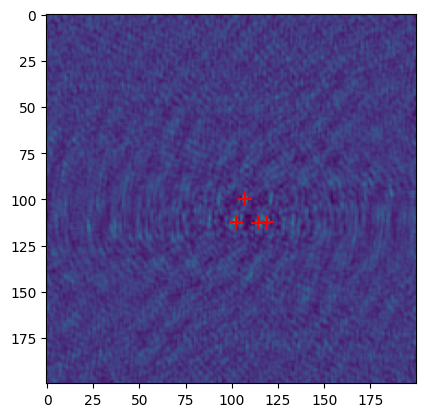

In [16]:
print(sources)
#dirty_im = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(grid[0, 0, :, :]))))
pl.imshow(dirty_im[0,0,:,:])
pl.scatter(sources[1], sources[0], color='red', marker='+', s=100) 
print(f'fluxes={dirty_im[0,0,sources[0][:], sources[1][:]]}')

This show that the 4 sources are as simulated the flux will deviate from true as a function of distance from centre as Van-Cittert Zernike is not really a 2-D FT.

**Compare with CASA** 
install gdown to download a casa data set that has model predicted in casa
and then down load the ms4 that has casa predicted model and the model image to be predicted 

In [20]:
!pip install gdown
import gdown
gdown.download(id='1ybyBA6e5XiGXja8CI9yMBEFaMcLz82gd', output='mod_image.npy', fuzzy=True)
gdown.download(id='19br3EYwdtu82iF4JkRaX-9u2_bhNAMjJ', output='lala.zip', fuzzy=True)
!unzip lala.zip

Looking in indexes: https://casa-pip.nrao.edu/repository/pypi-group/simple, https://pypi.org/simple
Downloading...
From: https://drive.google.com/uc?id=19br3EYwdtu82iF4JkRaX-9u2_bhNAMjJ
To: /home/heron/kgolap/astroviper/docs/core_tutorials/imaging/lala.zip
100%|██████████████████████████████████████| 1.46M/1.46M [00:00<00:00, 5.26MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ybyBA6e5XiGXja8CI9yMBEFaMcLz82gd
To: /home/heron/kgolap/astroviper/docs/core_tutorials/imaging/mod_image.npy
100%|████████████████████████████████████████| 524k/524k [00:00<00:00, 2.44MB/s]
Archive:  lala.zip
   creating: ngc5921_casa_model.ps.zarr/
  inflating: ngc5921_casa_model.ps.zarr/.zmetadata  
 extracting: ngc5921_casa_model.ps.zarr/.zattrs  
   creating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/
   creating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/frequency/
  inflating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/frequency/0  
  inflating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/freque

load the ms4 that has the casa model vis

In [26]:
from xradio.measurement_set import load_processing_set
import numpy as np
ngc_xdt=load_processing_set('ngc5921_casa_model.ps.zarr')
ngc_mod=ngc_xdt['ngc5921_model_0']

load another copy which we will use to predict the model image

In [23]:
ngc_xdt2=load_processing_set('ngc5921_casa_model.ps.zarr')
ngc_ms4=ngc_xdt2['ngc5921_model_0']

Lets see what the model image looks like

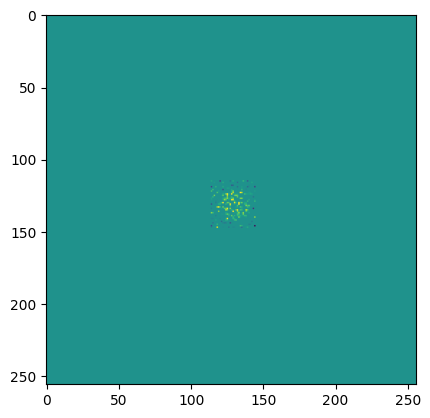

In [27]:
mod_arr=np.load('mod_image.npy')
pl.imshow(mod_arr, vmax=0.001599)

In [30]:
ft_mod = np.zeros([1,1,256,256], dtype=complex)
ft_mod[0,0,:,:] = fft_lm_to_uv(mod_arr, axes=[0, 1])

np.max(ft_mod)

np.complex128(0.11063294959603809+0j)

image has cell size of 15arcsec

In [31]:
from astropy import units as u
incr=(15*u.arcsec).to('rad').value

In [32]:
from astroviper.core.imaging.imaging_utils.standard_degrid import degrid_spheroid_ms4

In [33]:
%timeit degrid_spheroid_ms4(vis=ngc_ms4, grid=ft_mod, pixelincr=np.array([-incr, incr]), support=7, sampling=100, whichFunc=0)

624 ms ± 7.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


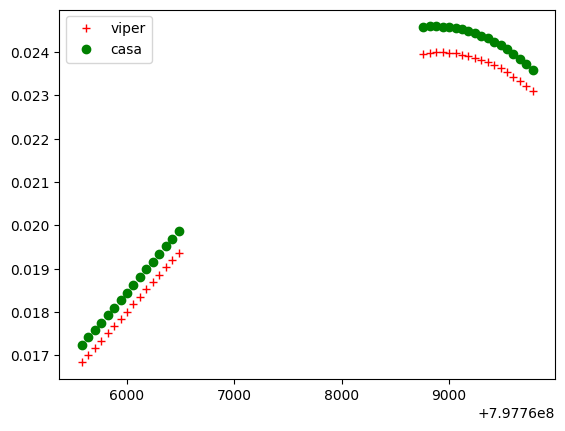

In [34]:
this_mod=ngc_ms4.VISIBILITY_MODEL
casa_mod=ngc_mod.VISIBILITY_MODEL
pl.plot(this_mod.isel(baseline_id=100, frequency=35, polarization=0).time, np.abs(this_mod.isel(baseline_id=200, frequency=35, polarization=0)), '+r', label='viper')
pl.plot(casa_mod.isel(baseline_id=100, frequency=35, polarization=0).time, np.abs(casa_mod.isel(baseline_id=200, frequency=35, polarization=0)),'og', label='casa')
pl.legend()

Let's try with code that has been optimized with vecor mult with the help of Gemini

In [35]:
%timeit degrid_spheroid_ms4(vis=ngc_ms4, grid=ft_mod, pixelincr=np.array([-incr, incr]), support=7, sampling=100, whichFunc=1)

1.19 s ± 9.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Vectorize vs loop seems to be overated for jit code**

Have not found why there is a difference in casa vs viper ...shifting uv points by rounding differently have similar differences.
